In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
! ls /data/sg/ashutiwa/final_crosswalk/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec.npy
airport_test_adj.npz


In [4]:
y = snakemake_utils.get_dataset("polblog").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk/polblog/'

DIRS = ['polblog_one/', 'polblog_two/', 'polblog_three/', 'polblog_four/', 'polblog_five/']
DATASET = 'polblog'

model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    
}
M = list(model_to_embs.keys())


TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk/polblog/polblog_one/polblog_test_adj.npz'
NUM_NODES=1224
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# fairwalk+deepwalk

In [8]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


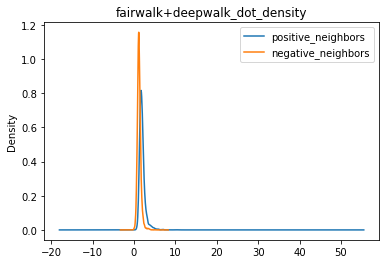

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2539.73it/s]


((6116, 2), 0.003602144343619273, 0.8629183497393763, 0.23446279295231562)

# fairwalk+node2vec

In [11]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12169


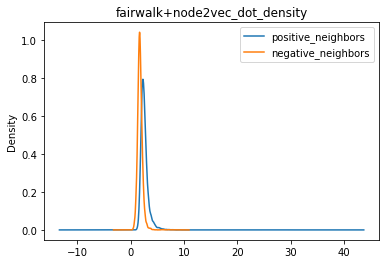

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2775.52it/s]


((6114, 2), 0.003930508404688883, 0.878195756004571, 0.25494168756118873)

# crosswalk+deepwalk

In [14]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


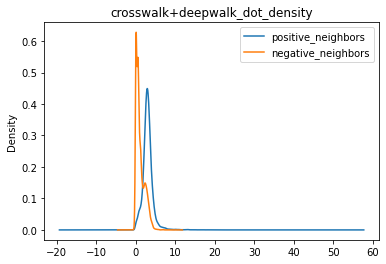

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4504.60it/s]


((6116, 2), 0.004555714284012996, 0.8804122531044948, 0.3050694218534095)

# crosswalk+node2vec

In [17]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


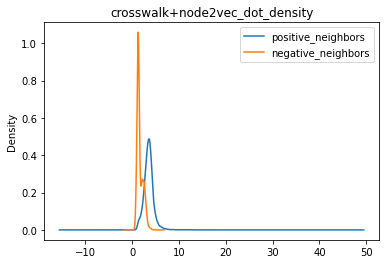

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3411.23it/s]


((6112, 2), 0.004686876510100445, 0.9443812241844711, 0.3078403636490835)

# GCN+deepwalk+random

In [20]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


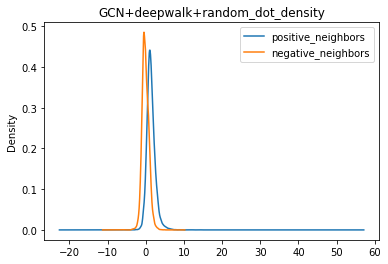

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3425.71it/s]


((6120, 2), 0.004386005044610943, 0.86137787854873, 0.3000161127175673)

# GCN+deepwalk+r2v

In [23]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12169


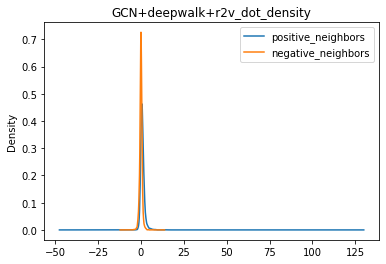

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1726.03it/s]


((6120, 2), 0.003031489689783256, 0.7710660363844412, 0.22704227853750364)

# GCN+node2vec+random

In [26]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


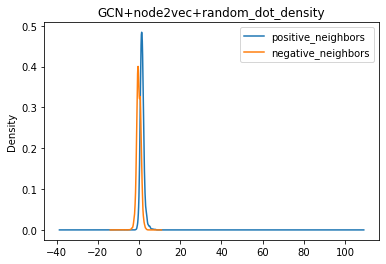

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3875.67it/s]


((6120, 2), 0.004377483701633591, 0.8829469028847646, 0.29896427052365776)

# GCN+node2vec+r2v

In [29]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


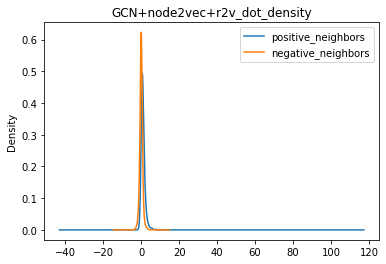

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3779.32it/s]


((6120, 2), 0.0027348387053218, 0.7909216714360925, 0.20752913531521497)

# GAT+deepwalk+random

In [32]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


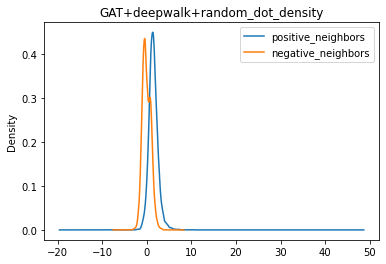

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2940.06it/s]


((6120, 2), 0.004408445318067322, 0.8675830595196214, 0.30596125314785977)

# GAT+deepwalk+r2v

In [35]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


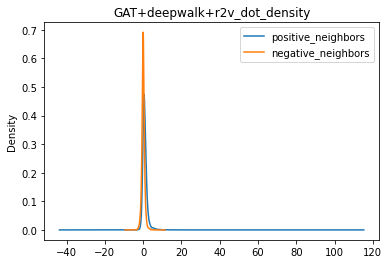

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2031.80it/s]


((6120, 2), 0.0028996068146495356, 0.7461112438318266, 0.217097407590265)

# GAT+node2vec+random

In [38]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


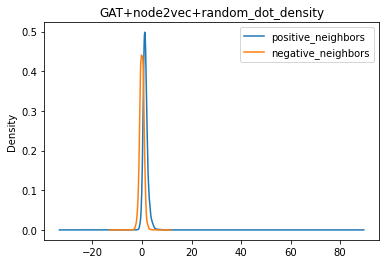

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3725.99it/s]


((6120, 2), 0.004281295143749845, 0.8812900488660664, 0.2912804147382304)

# GAT+node2vec+r2v

In [41]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12169


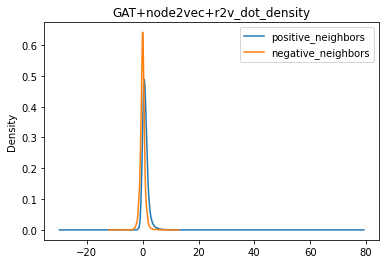

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4712.96it/s]


((6120, 2), 0.0028739478522258376, 0.7859345411436915, 0.21688082251968985)

# plot statistical parity scores

# gini sp scores

fairwalk+deepwalk 0.23446279295231562
fairwalk+node2vec 0.25494168756118873
crosswalk+deepwalk 0.3050694218534095
crosswalk+node2vec 0.3078403636490835
GCN+deepwalk+random 0.3000161127175673
GCN+deepwalk+r2v 0.22704227853750364
GCN+node2vec+random 0.29896427052365776
GCN+node2vec+r2v 0.20752913531521497
GAT+deepwalk+random 0.30596125314785977
GAT+deepwalk+r2v 0.217097407590265
GAT+node2vec+random 0.2912804147382304
GAT+node2vec+r2v 0.21688082251968985


Text(0.5, 1.0, 'gini statistical parity scores')

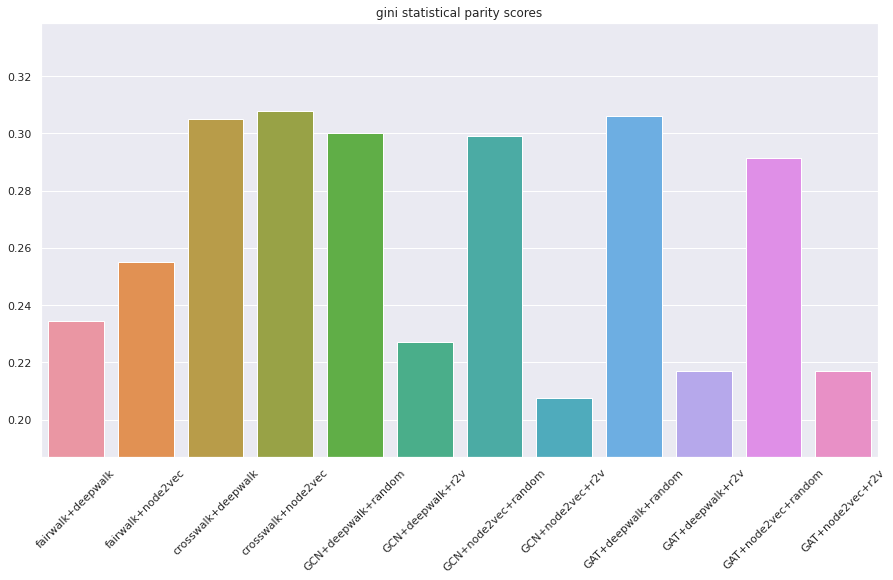

In [44]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

fairwalk+deepwalk 0.003602144343619273
fairwalk+node2vec 0.003930508404688883
crosswalk+deepwalk 0.004555714284012996
crosswalk+node2vec 0.004686876510100445
GCN+deepwalk+random 0.004386005044610943
GCN+deepwalk+r2v 0.003031489689783256
GCN+node2vec+random 0.004377483701633591
GCN+node2vec+r2v 0.0027348387053218
GAT+deepwalk+random 0.004408445318067322
GAT+deepwalk+r2v 0.0028996068146495356
GAT+node2vec+random 0.004281295143749845
GAT+node2vec+r2v 0.0028739478522258376


Text(0.5, 1.0, 'statistical parity scores')

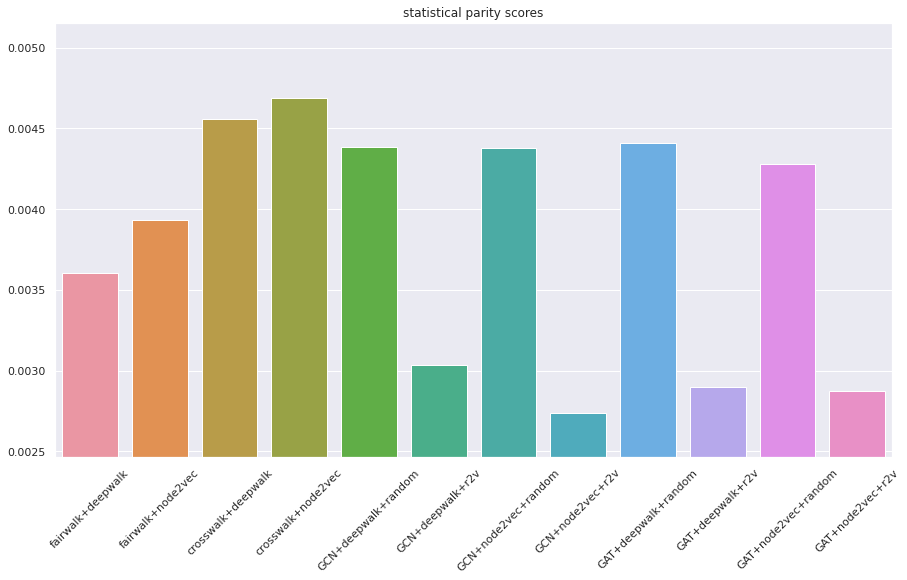

In [45]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

fairwalk+deepwalk 0.8629183497393763
fairwalk+node2vec 0.878195756004571
crosswalk+deepwalk 0.8804122531044948
crosswalk+node2vec 0.9443812241844711
GCN+deepwalk+random 0.86137787854873
GCN+deepwalk+r2v 0.7710660363844412
GCN+node2vec+random 0.8829469028847646
GCN+node2vec+r2v 0.7909216714360925
GAT+deepwalk+random 0.8675830595196214
GAT+deepwalk+r2v 0.7461112438318266
GAT+node2vec+random 0.8812900488660664
GAT+node2vec+r2v 0.7859345411436915


Text(0.5, 1.0, 'roc scores')

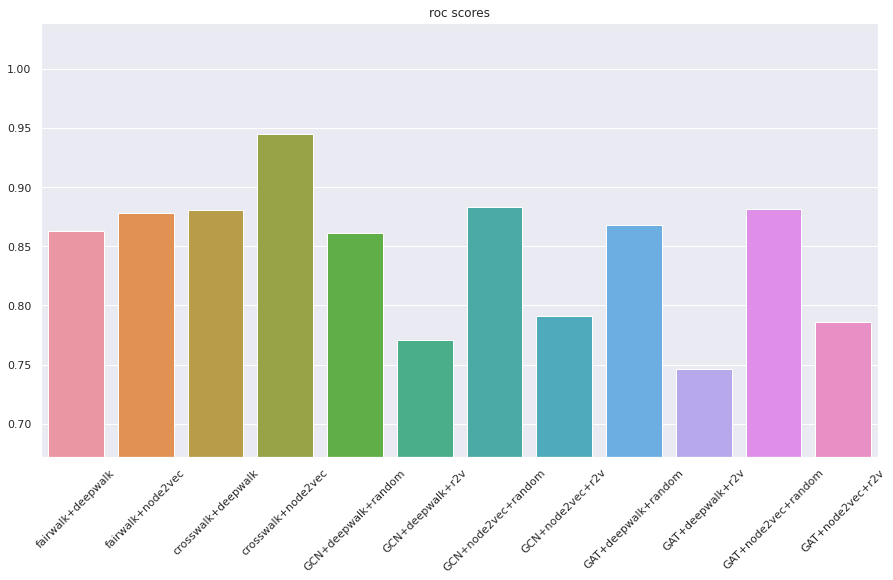

In [46]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [47]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2261.30it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2000.75it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4636.77it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1782.58it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1414.32it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2924.86it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4901.01it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3079.04it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3744.75it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4680.12it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2387.95it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2842.36it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3221.68it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3264.01it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2362.55it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1987.54it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1568.32it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3766.75it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4786.76it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3975.95it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2098.32it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4523.32it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3516.68it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3556.37it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4362.44it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3211.69it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3883.20it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

Text(0.5, 1.0, 'gini scores vs # nn')

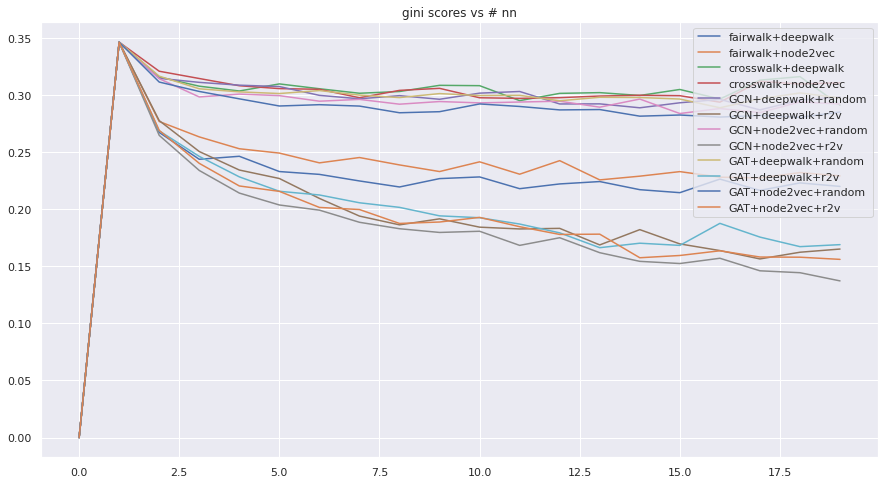

In [48]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

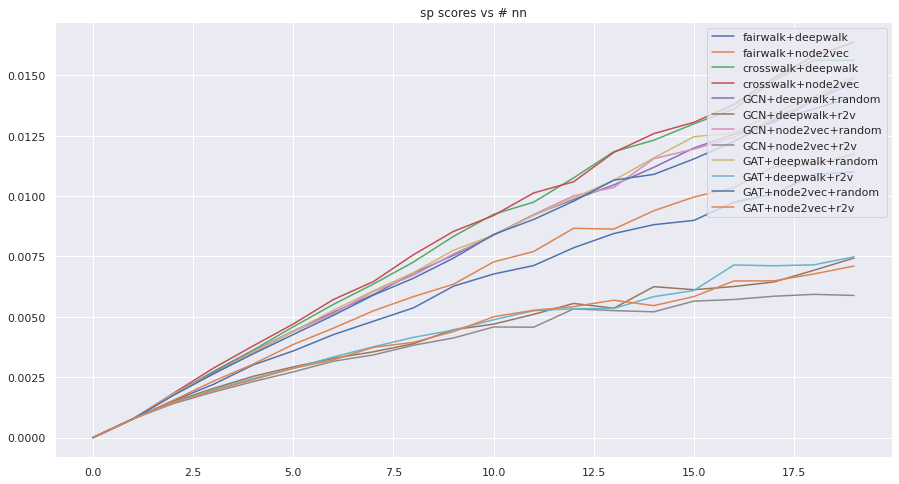

In [49]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [50]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected e

Text(0.5, 1.0, 'roc scores')

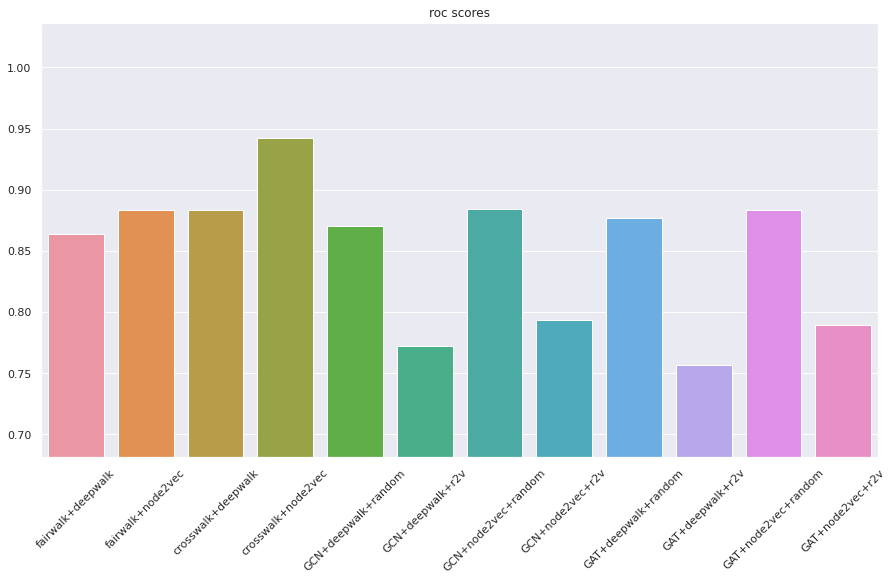

In [51]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4013.75it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3912.36it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3885.03it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3605.74it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2011.72it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4647.13it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4993.90it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3558.99it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2343.23it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

fairwalk+deepwalk 0.003658756779061409
fairwalk+node2vec 0.003882579271044412
crosswalk+deepwalk 0.0046959635142123455
crosswalk+node2vec 0.004692338402924429
GCN+deepwalk+random 0.004469521628440752
GCN+deepwalk+r2v 0.003201124265448929
GCN+node2vec+random 0.004398798324003475
GCN+node2vec+r2v 0.0029816782177001845
GAT+deepwalk+random 0.0044213504635274015
GAT+deepwalk+r2v 0.0029871222205803422
GAT+node2vec+random 0.004377074114810799
GAT+node2vec+r2v 0.002851396671042966


Text(0.5, 1.0, 'statistical parity scores')

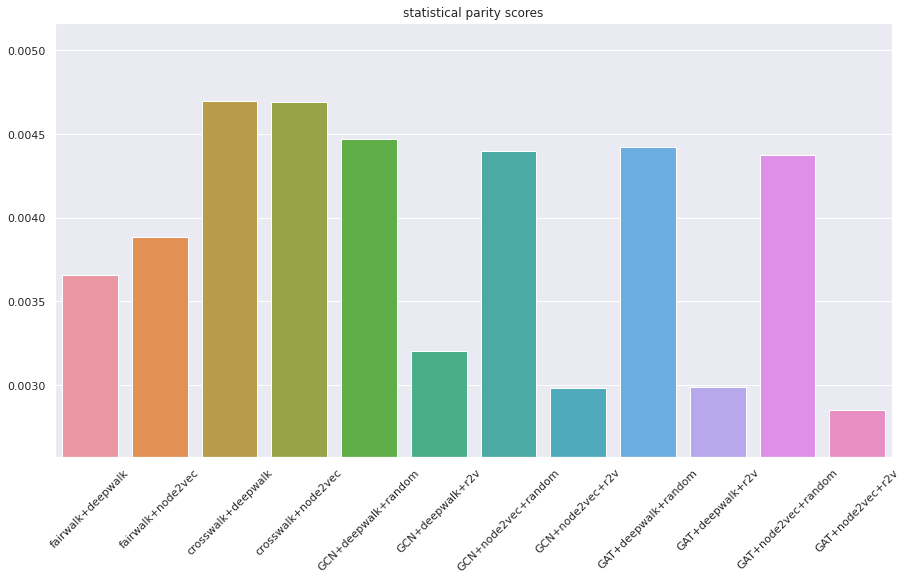

In [52]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.23786942307781528
fairwalk+node2vec 0.255472765360783
crosswalk+deepwalk 0.3118292441319289
crosswalk+node2vec 0.30368894050863526
GCN+deepwalk+random 0.30550664910365066
GCN+deepwalk+r2v 0.2343078882000301
GCN+node2vec+random 0.3015893903196101
GCN+node2vec+r2v 0.22161936525899706
GAT+deepwalk+random 0.3034270636552278
GAT+deepwalk+r2v 0.2229646074899292
GAT+node2vec+random 0.29801837917484203
GAT+node2vec+r2v 0.21564997940841052


Text(0.5, 1.0, 'gini statistical parity scores')

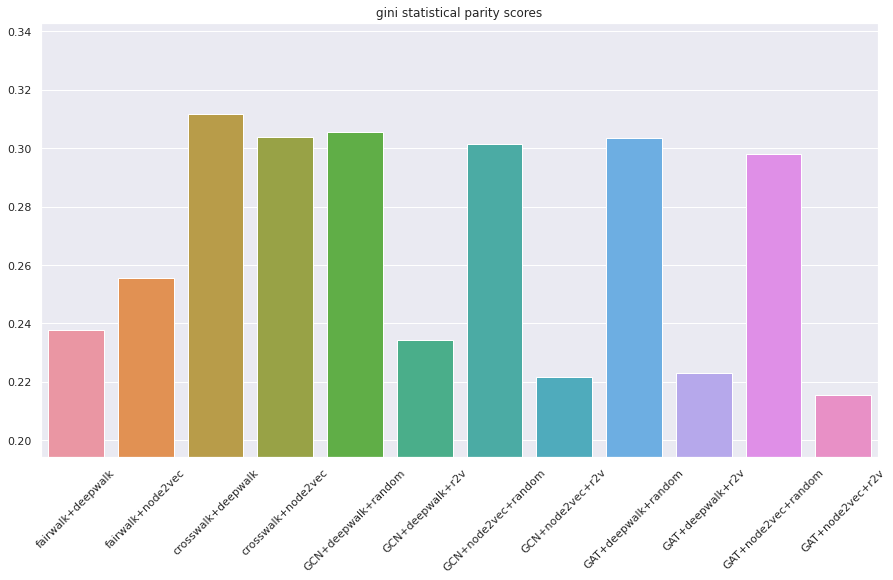

In [53]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [54]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected edge_idx size: 12952
selected edge_idx size: 13034
selected edge_idx size: 12169
selected edge_idx size: 13129
selected edge_idx size: 12154
selected e

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4661.19it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3162.93it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3165.20it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3746.50it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4604.89it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3575.61it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5101.54it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3872.39it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3350.13it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████